In [29]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}<style>"))

In [1]:
import numpy as np
import tensorflow as tf
from keras import layers, Input, Model, Sequential, optimizers
from keras.layers import Reshape, Merge, Lambda, Add, Subtract, dot
from keras.layers import Layer, Dense, Dropout, Activation, Flatten, Reshape, Permute
from keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.optimizers import Adam, SGD
from keras.preprocessing import image
import keras.backend as K
from keras.regularizers import l2
from keras.engine import Layer
from keras.utils import multi_gpu_model, np_utils
from keras.models import load_model
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
import random

GPU_MEMORY_FRACTION = 0.5
DATA_SHAPE = 224

Using TensorFlow backend.


In [2]:
def config_keras_backend(fraction):
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.gpu_options.per_process_gpu_memory_fraction = fraction 
    sess = tf.Session(config=config)
    K.set_session(sess)
    
train_labels = np.load('/home/mc16/pre_data/train_label_%s.npy'%DATA_SHAPE)
val_labels = np.load('/home/mc16/pre_data/val_label_%s.npy'%DATA_SHAPE)
train_images = np.load('/home/mc16/pre_data/train_image_%s.npy'%DATA_SHAPE)
val_images = np.load('/home/mc16/pre_data/val_image_%s.npy'%DATA_SHAPE)

# Model

In [4]:
def segnet(shape=224):
    kernel = 3
    filter_size = 64
    pad = 1
    pool_size = 2
    model = Sequential()
    model.add(Layer(input_shape=(shape , shape ,3)))
    # encoder
    model.add(ZeroPadding2D(padding=(pad,pad)))
    model.add(Conv2D(filter_size, (kernel, kernel), padding='valid'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
    model.add(ZeroPadding2D(padding=(pad,pad)))
    model.add(Conv2D(128, (kernel, kernel), padding='valid'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
    model.add(ZeroPadding2D(padding=(pad,pad)))
    model.add(Conv2D(256, (kernel, kernel), padding='valid'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
    model.add(ZeroPadding2D(padding=(pad,pad)))
    model.add(Conv2D(512, (kernel, kernel), padding='valid'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    # decoder
    model.add( ZeroPadding2D(padding=(pad,pad)))
    model.add( Conv2D(512, (kernel, kernel), padding='valid'))
    model.add( BatchNormalization())
    model.add( UpSampling2D(size=(pool_size,pool_size)))
    model.add( ZeroPadding2D(padding=(pad,pad)))
    model.add( Conv2D(256, (kernel, kernel), padding='valid'))
    model.add( BatchNormalization())
    model.add( UpSampling2D(size=(pool_size,pool_size)))
    model.add( ZeroPadding2D(padding=(pad,pad)))
    model.add( Conv2D(128, (kernel, kernel), padding='valid'))
    model.add( BatchNormalization())
    model.add( UpSampling2D(size=(pool_size,pool_size)))
    model.add( ZeroPadding2D(padding=(pad,pad)))
    model.add( Conv2D(filter_size, (kernel, kernel), padding='valid'))
    model.add( BatchNormalization())
    model.add(Conv2D(2, (1, 1), padding='valid',))
    model.outputHeight = model.output_shape[-2]
    model.outputWidth = model.output_shape[-3] 
    model.add(Activation('softmax'))
    return model

def mycrf(unary, image): 
    q0 = unary
    
    f1 = Conv2D(2, (3, 3), padding='same')(image)
    m1 = Lambda(lambda x: K.tf.multiply(x[0], x[1]))([f1, q0])
    r1 = Conv2D(2, (1, 1), padding='same')(m1) 
    p1 = Conv2D(2, (1, 1), padding='same')(r1)
    q1 = Subtract()([unary, p1])
    q1 = Activation('softmax')(q1)
    
    f2 = Conv2D(2, (3, 3), padding='same')(image)
    m2 = Lambda(lambda x: K.tf.multiply(x[0], x[1]))([f2, q1])
    r2 = Conv2D(2, (1, 1), padding='same')(m2)
    p2 = Conv2D(2, (1, 1), padding='same')(r2)
    q2 = Subtract()([unary, p2])
    q2 = Activation('softmax')(q2)
    
    f3 = Conv2D(2, (3, 3), padding='same')(image)
    m3 = Lambda(lambda x: K.tf.multiply(x[0], x[1]))([f3, q2])
    r3 = Conv2D(2, (1, 1), padding='same')(m3)
    p3 = Conv2D(2, (1, 1), padding='same')(r3)
    q3 = Subtract()([unary, p3])
    q3 = Activation('softmax')(q3)
    
    f4 = Conv2D(2, (3, 3), padding='same')(image)
    m4 = Lambda(lambda x: K.tf.multiply(x[0], x[1]))([f4, q3])
    r4 = Conv2D(2, (1, 1), padding='same')(m4)
    p4 = Conv2D(2, (1, 1), padding='same')(r4)
    q4 = Subtract()([unary, p4])
    q4 = Activation('softmax')(q4)
    
    f5 = Conv2D(2, (3, 3), padding='same')(image)
    m5 = Lambda(lambda x: K.tf.multiply(x[0], x[1]))([f5, q4])
    r5 = Conv2D(2, (1, 1), padding='same')(m5)
    p5 = Conv2D(2, (1, 1), padding='same')(r5)
    q5 = Subtract()([unary, p5])
    q5 = Activation('softmax')(q5)
    
    return q5

def mysegcrf(shape):
    input_img = Input(shape=(shape, shape, 3))
    input_nor = Lambda(lambda x: x/127.5 - 1.)(input_img)
    seg = segnet(DATA_SHAPE)
#     seg = load_model('seg0608.h5')
    for layer in seg.layers:
        layer.trainable = False
    unary = seg(input_nor)
    q_value = mycrf(unary, input_nor)
    model = Model(inputs=input_img, outputs=q_value)
    return model

def weighted_categorical_crossentropy(weights):
    weights = K.variable(weights)
    def loss(y_true, y_pred):
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    return loss

# Train

In [6]:
config_keras_backend(GPU_MEMORY_FRACTION)
segcrf = mysegcrf(DATA_SHAPE)
parallel_segcrf = multi_gpu_model(segcrf,gpus=8)

InternalError: Failed to create session.

In [28]:
BATCH_SIZE = 128
LEARNING_RATE = 1e-4
EPOCHS = 10
CLASS_WEIGHT = np.array([1,10])

loss = weighted_categorical_crossentropy(CLASS_WEIGHT)
adam = Adam(lr=LEARNING_RATE)
parallel_segcrf.compile(loss=loss, optimizer=adam, metrics=['accuracy'])
parallel_segcrf.fit(x = train_images, 
                     y = train_labels,
                     batch_size = BATCH_SIZE,
                     epochs = EPOCHS,
                     verbose = 1,
                     validation_data = (val_images, val_labels),
                     shuffle = True)

Train on 20000 samples, validate on 2015 samples
Epoch 1/10
20000/20000 [==============================] - 84s 4ms/step - loss: 0.9067 - acc: 0.6000 - val_loss: 0.8790 - val_acc: 0.7384
Epoch 2/10
20000/20000 [==============================] - 67s 3ms/step - loss: 0.8920 - acc: 0.6286 - val_loss: 0.8670 - val_acc: 0.7568
Epoch 3/10
20000/20000 [==============================] - 68s 3ms/step - loss: 0.8792 - acc: 0.6508 - val_loss: 0.8557 - val_acc: 0.7758
Epoch 4/10
20000/20000 [==============================] - 67s 3ms/step - loss: 0.8662 - acc: 0.6678 - val_loss: 0.8418 - val_acc: 0.8035
Epoch 5/10
20000/20000 [==============================] - 67s 3ms/step - loss: 0.8482 - acc: 0.6901 - val_loss: 0.8194 - val_acc: 0.8903
Epoch 6/10
20000/20000 [==============================] - 68s 3ms/step - loss: 0.8196 - acc: 0.7249 - val_loss: 0.7901 - val_acc: 0.9606
Epoch 7/10
20000/20000 [==============================] - 68s 3ms/step - loss: 0.7855 - acc: 0.7740 - val_loss: 0.7620 - val_acc:

# Test

In [3]:
import cv2
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from keras.models import model_from_json
from keras.models import load_model
import os

def read_paths(dataset_path, list_path):
    imagepaths = []
    labelpaths = []
    for path in tqdm(open(list_path)):
        md5 = path.split('.')[0]
        imagepaths.append(dataset_path + "images/%s.jpg"%md5)
        labelpaths.append(dataset_path + "spline_labels/%s.json"%md5)
    return imagepaths, labelpaths

# detect points for one image
def detect_points(img, model, shape):
    img = cv2.resize(img, (shape,shape))
    img = np.expand_dims(img,axis=0)
    points_logist = model.predict(img)
    points = np.argmax(points_logist, axis=-1)
    return points[0]

val_set_path = '/data/mc_data/MLDC/data/val/'
val_list_path = '/data/mc_data/MLDC/data/val/list.txt'
val_image_paths, val_label_paths = read_paths(val_set_path, val_list_path)
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "7"
GPU_MEMORY_FRACTION = 1.0
config_keras_backend(GPU_MEMORY_FRACTION)
model = load_model('seg0608.h5')

2015it [00:00, 313611.73it/s]
/home/mc16/.local/lib/python2.7/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


1398


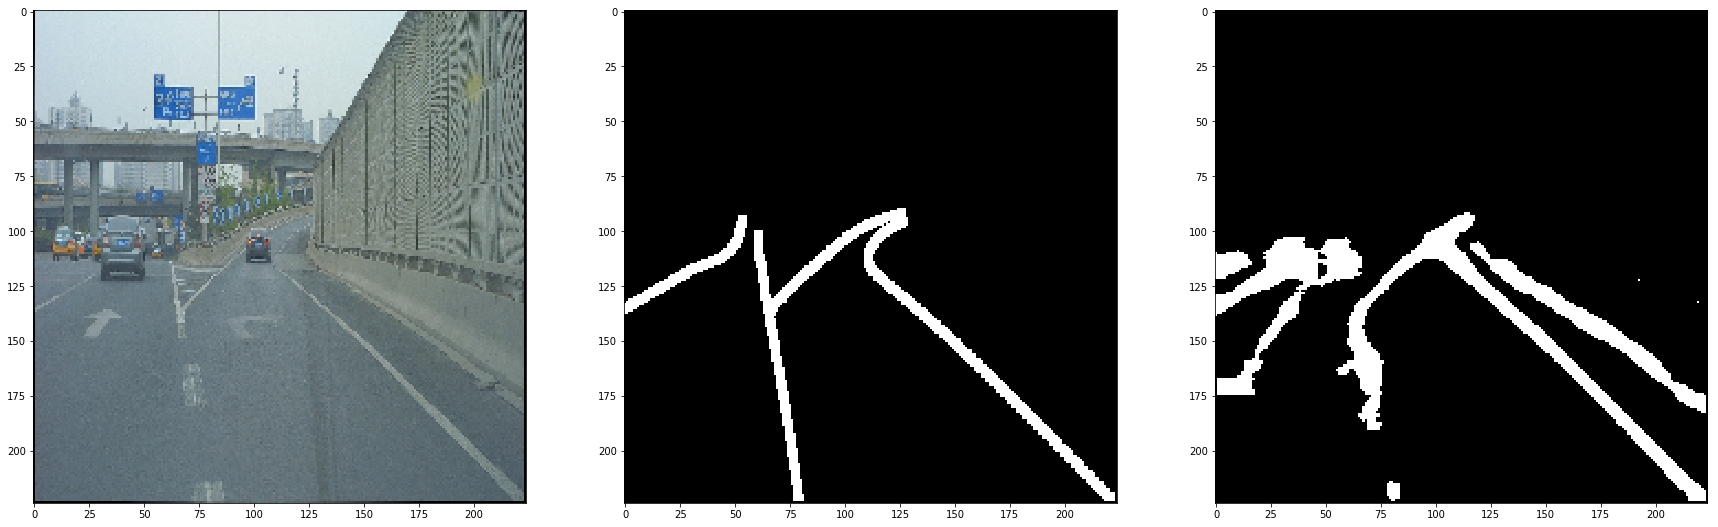

In [6]:
# show the detected points on a valid image
test_index = random.randint(0, len(val_labels))
# test_index = 538
print(test_index)
test_label = val_labels[test_index,:,:,1]
test_img = plt.imread(val_image_paths[test_index])
test_img = cv2.resize(test_img,(DATA_SHAPE,DATA_SHAPE))
test_points = detect_points(test_img, model, DATA_SHAPE)
fig, axs = plt.subplots(1, 3, figsize=(30,30)) 
axs[0].imshow(test_img)
axs[1].imshow(test_label,cmap='gray')
axs[2].imshow(test_points,cmap='gray')
plt.show()

# Save result

In [7]:
# detect points for images set
def detect_test_list(model, shape):
    test_set_path = '/data/mc_data/MLDC/data/test1/images/' 
    test_md5_paths = open('/home/mc16/test1_list.txt','r').readlines()
    points_list = np.zeros((len(test_md5_paths), shape, shape), np.uint8)
    i = 0
    for path in tqdm(test_md5_paths):
        md5 = path.split('.')[0]
        img = plt.imread(test_set_path + md5 +'.jpg')
        points_logist = detect_points(img, model, shape)
        points_list[i] = points_logist
        i = i + 1
    return points_list

def detect_val_points(val_images, model, shape):
    points_list = np.zeros((len(val_images), shape, shape), np.uint8)
    i = 0
    for image in tqdm(val_images):
        points_list[i] = detect_points(image, model, shape)
        i = i + 1
    return points_list

# save detected points for images in test0 and val
import datetime
TIMEFORMAT = '%m-%d-%H:%M:%S'
# time = datetime.datetime.now().strftime(TIMEFORMAT)
# test_detect_points = detect_test_list(model, DATA_SHAPE)
# np.save("/home/mc16/result/test1_seg_%s.npy"%time, test_detect_points)
time = datetime.datetime.now().strftime(TIMEFORMAT)
val_detect_points = detect_val_points(val_images, model, DATA_SHAPE)
np.save("/home/mc16/result/val_seg_%s.npy"%time, val_detect_points)

100%|██████████| 2015/2015 [00:16<00:00, 121.94it/s]


# DenseCRF

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "4,5,6,7"
GPU_MEMORY_FRACTION = 0.01
config_keras_backend(GPU_MEMORY_FRACTION)
model = load_model('seg0608.h5')

NameError: name 'config_keras_backend' is not defined

In [ ]:
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import compute_unary, create_pairwise_bilateral, create_pairwise_gaussian, unary_from_softmax

def crf_image(img, model):
    img = cv2.resize(img, (DATA_SHAPE, DATA_SHAPE))
    score = model.predict(np.expand_dims(img,axis=0))
#     img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    softmax = score[0].transpose((2, 0, 1)) # [channel,shap,shape]
    # The input should be the negative of the logarithm of probability values
    # Look up the definition of the softmax_to_unary for more information
    unary = unary_from_softmax(softmax)
    # The inputs should be C-continious -- we are using Cython wrapper
    unary = np.ascontiguousarray(unary)#(2,n)
    crf = dcrf.DenseCRF(img.shape[0] * img.shape[1], 2)
    crf.setUnaryEnergy(unary)

    # This potential penalizes small pieces of segmentation that are
    # spatially isolated -- enforces more spatially consistent segmentations
    feats = create_pairwise_gaussian(sdims=(2, 3), shape=img.shape[:2])
    crf.addPairwiseEnergy(feats, compat=3, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

    # This creates the color-dependent features --
    # because the segmentation that we get from CNN are too coarse
    # and we can use local color features to refine them
    feats = create_pairwise_bilateral(sdims=(20, 100), schan=(20, 20, 20), img=img, chdim=2)
    crf.addPairwiseEnergy(feats, compat=10, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

    # mean field iteration
    Q = crf.inference(1)
    
    res = np.argmax(Q, axis=0).reshape((img.shape[0], img.shape[1]))
    return res    

In [ ]:
test_index = random.randint(0, len(val_labels))
# test_index = 100
test_label = val_labels[test_index,:,:,1]
test_img = plt.imread(val_image_paths[test_index])
test_img = cv2.resize(test_img,(DATA_SHAPE,DATA_SHAPE))
test_mask = crf_image(test_img, model)
test_points = detect_points(test_img, model, DATA_SHAPE)
fig, axs = plt.subplots(1, 4, figsize=(30,30)) 
axs[0].imshow(test_img)
axs[1].imshow(test_label,cmap='gray')
axs[2].imshow(test_points,cmap='gray')
axs[3].imshow(test_mask,cmap='gray')
plt.show()

In [18]:
def crf_test_images(model, shape):
    test_set_path = '/data/mc_data/MLDC/data/test1/images/' 
    test_md5_paths = open('/home/mc16/test1_list.txt','r').readlines()
    mask_list = np.zeros((len(test_md5_paths), shape, shape), np.uint8)
    i = 0
    for path in tqdm(test_md5_paths):
        md5 = path.split('.')[0]
        img = plt.imread(test_set_path + md5 +'.jpg')
        mask = crf_image(img, model)
        mask_list[i] = mask
        i = i + 1
    return mask_list

def crf_val_images(val_images, model, shape):
    mask_list = np.zeros((len(val_images), shape, shape), np.uint8)
    i = 0
    for image in tqdm(val_images):
        mask_list[i] = crf_image(image, model)
        i = i + 1
    return mask_list

import datetime
TIMEFORMAT = '%m-%d-%H:%M:%S'
test_masks = crf_test_images(model, DATA_SHAPE)
time = datetime.datetime.now().strftime(TIMEFORMAT)
np.save("/home/mc16/result/test_masks_%s.npy"%time, test_masks)
val_masks = crf_val_images(val_images, model, DATA_SHAPE)
time = datetime.datetime.now().strftime(TIMEFORMAT)
np.save("/home/mc16/result/val_masks_%s.npy"%time, val_masks)

100%|██████████| 2015/2015 [02:42<00:00, 12.38it/s]


## show image in test1

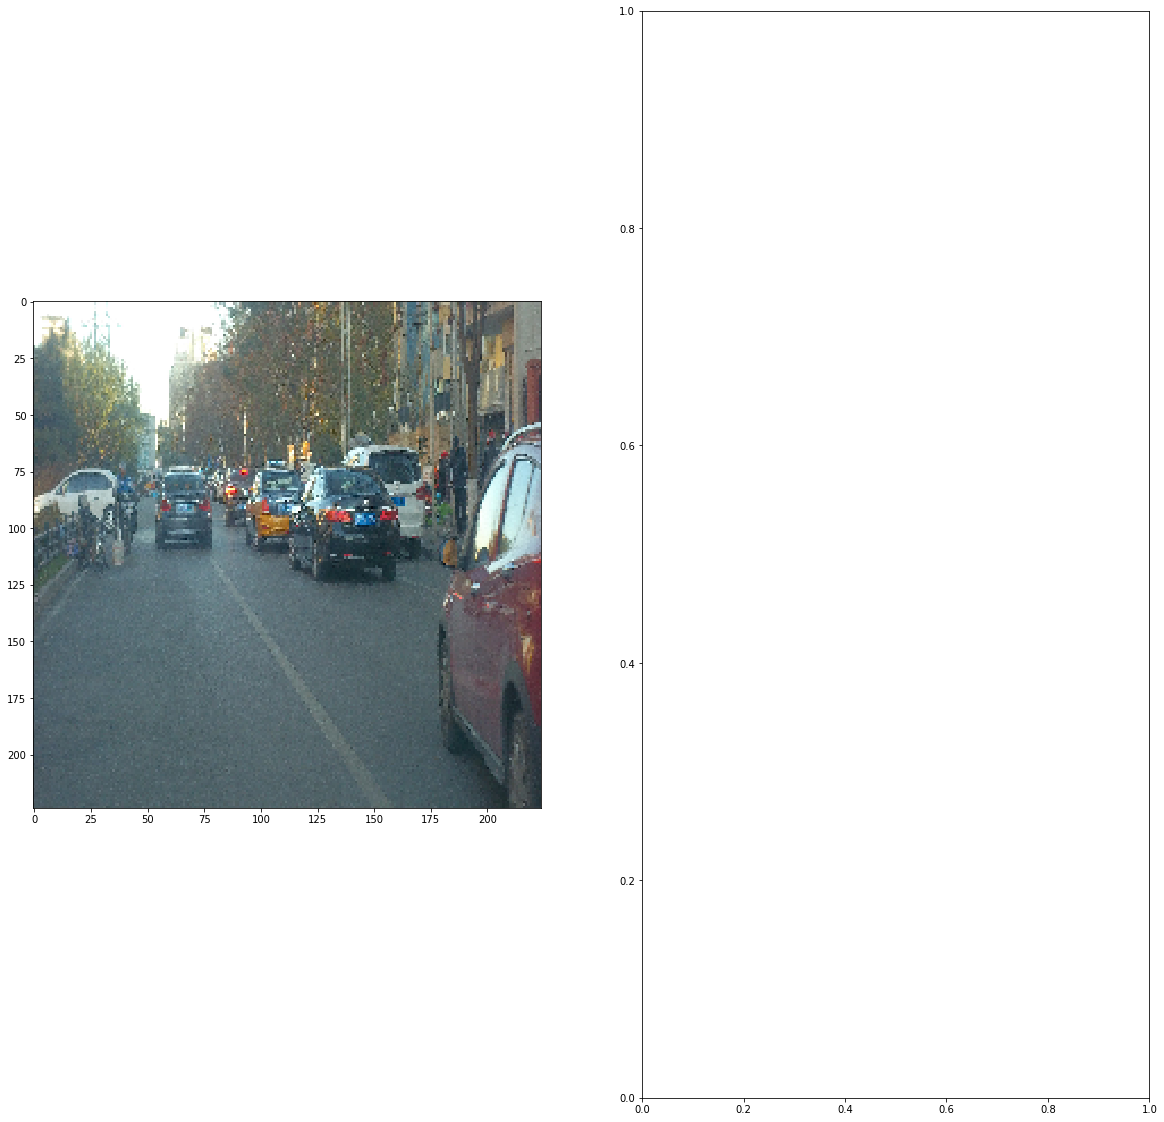

In [7]:
test_images =  np.load('/home/mc16/pre_data/test1_image_%s.npy'%DATA_SHAPE)
test_index = random.randint(0, len(test_images))
test_img = test_images[test_index]
# test_points = detect_points(test_img, model, DATA_SHAPE)
# test_mask = test_masks[test_index]
fig, axs = plt.subplots(1, 2, figsize=(20,20)) 
axs[0].imshow(test_img)
# axs[1].imshow(test_points,cmap='gray')
# axs[2].imshow(test_mask,cmap='gray')
plt.show()

In [16]:
test_index = random.randint(0, len(val_labels))
# test_index = 100
test_label = val_labels[test_index,:,:,1]
test_img = plt.imread(val_image_paths[test_index])
test_img = cv2.resize(test_img,(DATA_SHAPE,DATA_SHAPE))
test_mask = val_masks[test_index]
test_points = detect_points(test_img, model, DATA_SHAPE)
fig, axs = plt.subplots(1, 4, figsize=(30,30)) 
axs[0].imshow(test_img)
axs[1].imshow(test_label,cmap='gray')
axs[2].imshow(test_points,cmap='gray')
axs[3].imshow(test_mask,cmap='gray')
plt.show()

NameError: name 'val_masks' is not defined